In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# zapobieganie wypisywania notacji naukowej przez numpy
np.set_printoptions(suppress=True)

https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/

# Zbieranie i przygotowanie danych

### Załadowanie pliku

In [3]:
### Załadowanie dysku
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_file_path = "/content/drive/My Drive/Colab Notebooks/miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx"
try:
  df = pd.read_excel(data_file_path)
  if "Sposób prezentacji" in df.columns:
      # Filtrowanie danych
      df_poprzedni_miesiac_100 = df[df["Sposób prezentacji"] == "Poprzedni miesiąc = 100"].copy()

      print("Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.")
  else:
      print("Kolumna 'Sposób prezentacji' nie została znaleziona w pliku Excel.")
except FileNotFoundError:
    print(f"Błąd: Plik nie znaleziony pod ścieżką {data_file_path}")
except Exception as e:
    print(f"Wystąpił błąd podczas wczytywania pliku: {e}")

Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.


### Filtracja danych

In [5]:
# TODO: sprawdz co oznacza Flaga 'a' w roku 2000 i 2001
#df_poprzedni_miesiac_100[["Sposób prezentacji", "Rok", "Miesiąc", "Wartość", "Flaga"]]
data = df_poprzedni_miesiac_100[["Rok", "Miesiąc", "Wartość"]]
# pozbywamy się wierszy z wartościami NaN, występujące w roku 2025
data = data.dropna(subset=["Wartość"])
data = data.sort_values(by=['Rok','Miesiąc'], ascending=[1,1])

data_array = data.to_numpy()
# print(data.head(20))

Mając różnice pomiędzy następnymi miesiącami, usuwamy oulinery, które pokazują dużą różnicę inflacji.

In [6]:
# średnia arytmetyczna
mean = np.mean(data_array[:, 2:3], axis=0)
# odchylenie standardowe
sd = np.std(data_array[:, 2:3], axis=0)
top_limit = mean + 3 * sd
bottom_limit = mean - 3 * sd

# wypiszmy dane, które zostaną usunięte (oulinery)
for row in data_array:
  if (row[2] <= bottom_limit) or (row[2] >= top_limit):
    print(row)

data_array_filtered = [row for row in data_array if (row[2] > bottom_limit)]
data_array_filtered = [row for row in data_array_filtered if (row[2] < top_limit)]

[1982.     2.   136.3]
[1989.     8.   139.5]
[1989.     9.   134.4]
[1989.    10.   154.8]
[1989.    11.   122.4]
[1990.     1.   179.6]
[1990.     2.   123.8]


### Konwersja danych

inclacja - gdy "Wartość" > 100

deflacja - gdy "Wartość" < 100

In [7]:
# kolumna 0, rok
# kolumna 1, miesiąc
# kolumna 2, wartość względem grudnia 1981
data_len = len(data)
data_absolute_inflation = np.zeros((len(data), 3))
absolute_result = 1.0
idx = 0
for row in data_array:
  absolute_result = absolute_result + absolute_result * ((float(row[2])-100.0) / 100.0)
  data_absolute_inflation[idx] = [int(row[0]), int(row[1]), absolute_result]
  idx += 1
print(data_absolute_inflation)

[[1982.            1.            1.066     ]
 [1982.            2.            1.452958  ]
 [1982.            3.            1.53722956]
 ...
 [2025.            2.         3590.96204085]
 [2025.            3.         3598.14396493]
 [2025.            4.         3612.53654079]]


Wydaje mi się, że lepiej będzie można wykorzystać dane data_absolute_date_inflation, ponieważ tam mamy jedną kolumnę określającą czas, ale nie jestem pewien.

In [8]:
# kolumna 0, ilość miesięcy od grudnia 1982 (1 = dla styczeń 1982, 2 dla luty 1982, ..., 13 dla styczeń 1983, itd.)
# kolumna 1, wartość względem grudnia 1981
data_len = len(data)
data_absolute_date_inflation = np.zeros((len(data), 2))
absolute_result = 1.0
idx = 0
for row in data_array:
  absolute_result = absolute_result + absolute_result * ((float(row[2])-100.0) / 100.0)
  data_absolute_date_inflation[idx] = [(int(row[0])-1982)*12 + int(row[1]), absolute_result]
  idx += 1
print(data_absolute_date_inflation)

[[   1.            1.066     ]
 [   2.            1.452958  ]
 [   3.            1.53722956]
 ...
 [ 518.         3590.96204085]
 [ 519.         3598.14396493]
 [ 520.         3612.53654079]]


In [40]:
# Zaczynając od podanego miesiąca, zwraca dane z poprzednich miesięcy w postaci:
# [ostatnie miesiące], [ich inflacje]
def getData_of_last_months(month, number_of_months):
  if month - number_of_months <= 0:
    raise Exception("Nie można pobrać danych przed 1982 rokiem. Podaj późniejszy miesiąc, lub zmniejsz ilość miesięcy, którą chcesz pobrać.")
    return
  months = np.zeros((number_of_months, 1))
  inflation = np.zeros((number_of_months, 1))
  for i in range(number_of_months):
    months[i] = (month - number_of_months) + i - 1
    inflation[i] = data_array_filtered[(month - number_of_months) + i - 1][2]
  return months, inflation

# Zaczynając od podanego miesiąca, zwraca dane z poprzednich miesięcy w postaci:
# [ostatnie miesiące], [ich inflacje]
def getInflation_of_last_months(month, number_of_months):
  if month - number_of_months <= 0:
    raise Exception("Nie można pobrać danych przed 1982 rokiem. Podaj późniejszy miesiąc, lub zmniejsz ilość miesięcy, którą chcesz pobrać.")
    return
  inflation = np.zeros((number_of_months, 1))
  for i in range(number_of_months):
    inflation[i] = data_array_filtered[(month - number_of_months) + i - 1][2]
  return inflation


### Podział danych na uczące i testujące

In [9]:
## losowy podział danych
# X = data_absolute_inflation[:, 0:2] # daty
# y = data_absolute_inflation[:, 2]   # inflacja
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Podział danych na 80% danych uczących, tj. od styczeń 1882 do września 2016 roku.

In [10]:
# procent_danych_testowych = 0.8

# X = data_absolute_inflation[:, 0:2] # daty
# y = data_absolute_inflation[:, 2]   # inflacja
# x_len = int(len(X) * procent_danych_testowych)
# y_len = int(len(y) * procent_danych_testowych)
# X_train = X[:x_len]
# X_test = X[x_len:]
# y_train = y[:y_len]
# y_test = y[y_len:]
# print(f"Przedział dat danych trenujących: 0{int(X_train[0][1])}.{int(X_train[0][0])} - 0{int(X_train[-1][1])}.{int(X_train[-1][0])}")
# print(f"Przedział dat danych testowych:   0{int(X_test[0][1])}.{int(X_test[0][0])} - 0{int(X_test[-1][1])}.{int(X_test[-1][0])}")

Przedział dat danych trenujących: 01.1982 - 08.2016
Przedział dat danych testowych:   09.2016 - 04.2025


In [54]:
PROCENT_DANYCH_UCZACYCH = 0.8
ILOSC_DNI_POPRZEDNICH = 11
X, y = [], []
for i in range(ILOSC_DNI_POPRZEDNICH+2, len(data_array_filtered)):
  X.append(getInflation_of_last_months(i-1, ILOSC_DNI_POPRZEDNICH).flatten())
  y.append(data_array_filtered[i][2])
X = np.array(X) # inflacje w poprzednich miesiącach, np. [inflacja_styczen, inflacja_luty]
y = np.array(y) # inflacja w aktualnym miesiącu      np. [inflacja_marzec]

x_len = int(len(X) * PROCENT_DANYCH_UCZACYCH)
y_len = int(len(y) * PROCENT_DANYCH_UCZACYCH)
X_train = X[:x_len]
X_test = X[x_len:]
y_train = y[:y_len]
y_test = y[y_len:]

# print(X[0])
# print(y[0])
# print(data_array_filtered[0:12])

[106.6 105.8 103.1 102.7 100.9 103.9  99.4 100.3 101.4 100.9 100.8]
101.9
[array([1982. ,    1. ,  106.6]), array([1982. ,    3. ,  105.8]), array([1982. ,    4. ,  103.1]), array([1982. ,    5. ,  102.7]), array([1982. ,    6. ,  100.9]), array([1982. ,    7. ,  103.9]), array([1982. ,    8. ,   99.4]), array([1982. ,    9. ,  100.3]), array([1982. ,   10. ,  101.4]), array([1982. ,   11. ,  100.9]), array([1982. ,   12. ,  100.8]), array([1983. ,    1. ,  101.9])]


# Budowa i trenowanie modelu

In [74]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(solver="adam", hidden_layer_sizes=(5,10,5), max_iter=2200)

model.fit(X, y)
print('score:', model.score(X,y))
# print('predictions:', model.predict(X))

score: 0.3939513940142225


RNN - Recursive Neural Network

In [77]:
!pip install tensorflow matplotlib

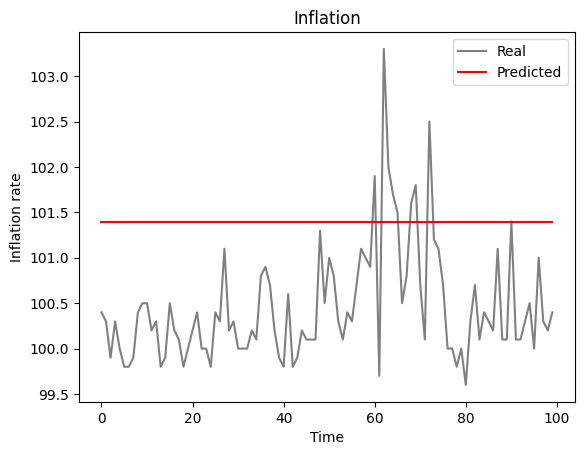

In [111]:
# COS NIE CHCE DZIALAC

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.random import set_seed
set_seed(455)
np.random.seed(455)

sc = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = sc.fit_transform(X_train)
y_train_scaled = sc.fit_transform(y_train)

# The LSTM architecture
n_steps = 11
features = 1

model_lstm = Sequential()
model_lstm.add(GRU(units=125, input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1, activation='linear'))
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()
model_lstm.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32)

predicted_stock_price = model_lstm.predict(X_test)

def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Inflation")
    plt.xlabel("Time")
    plt.ylabel("Inflation rate")
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

plot_predictions(y_test,predicted_stock_price)